In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
BASE_PATH = './..'
sys.path.append(BASE_PATH)

from dynaphos import utils
from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex, Map
from dynaphos.image_processing import canny_processor, sobel_processor
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator
from dynaphos.utils import get_data_kwargs, to_numpy
from dynaphos import cortex_models

import torch

from matplotlib_scalebar.scalebar import ScaleBar

In [ ]:
# Load colorstyles 
# plt.style.use('../_figurestyle/small.mplstyle')
# COLORSTYLE = utils.load_params('../_figurestyle/colors.yaml')

# LINE_COLOR = COLORSTYLE['red'][1]
# BOUNDS_COLOR = COLORSTYLE['turquoise'][2]

In [ ]:
# import yaml
# import numpy as np

# # grid size and spacing
# n_electrodes = 32
# spacing = 0.7  # mm between adjacent electrodes

# # compute how far from center to edge
# half_extent = (n_electrodes - 1) * spacing / 2

# # generate equally‐spaced coordinates from -half_extent to +half_extent
# coords_x = np.linspace(15, 15+2*half_extent, n_electrodes)
# coords_y = np.linspace(-half_extent, half_extent, n_electrodes)

# # form mesh of all (x,y) pairs
# x = []
# y = []
# for xi in coords_x:
#     for yi in coords_y:
#         x.append(float(xi))
#         y.append(float(yi))

# # pack into a dict and dump to yaml
# coords = {'x': x, 'y': y}
# output_path = '../electrode_schemes/yaml/biggrid.yaml'
# with open(output_path, 'w') as f:
#     yaml.dump(coords, f)

# print(f'Wrote {n_electrodes} by {n_electrodes} grid centered at fovea to {output_path}')


Wrote 32 by 32 grid centered at fovea to ../electrode_schemes/yaml/biggrid.yaml


In [4]:
import pickle

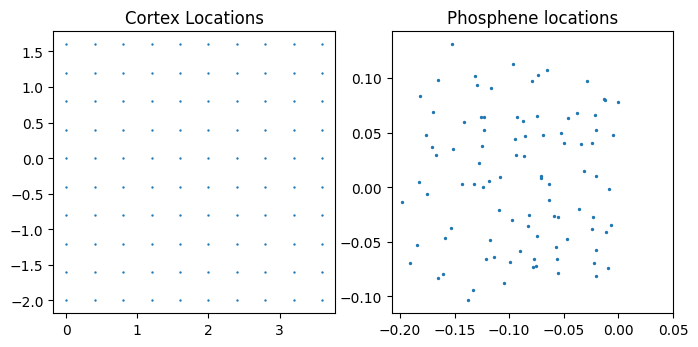

In [81]:
PLOT_TRUE_CORTEX_LOCATIONS = False # set true for plotting the distorted cortex locations corresponding to the phosphenes. 


# read parameters from yaml file
# params = utils.load_params(os.path.join(BASE_PATH, 'config','params.yaml'))
params = utils.load_params(os.path.join(BASE_PATH, 'config','params.yaml'))

# initialise phopshene locations, either using a cortex model or semi-probabilistically
x,y = utils.load_coordinates_from_yaml(os.path.join(BASE_PATH, 'electrode_schemes', 'yaml', '1utaharray.yaml'))
coordinates_cortex = Map(x,y)
params['cortex_model']['dropout_rate'] = 0.001
params['cortex_model']['noise_scale'] = 0.25
coordinates_visual_field = get_visual_field_coordinates_from_cortex(params['cortex_model'], coordinates_cortex)
# load from /home/mappel/Dynaphos/spatial_frequency/electrode_schemes/defaultcoordinatemap_1024.pickle
# coordinates_visual_field = pickle.load(open(os.path.join(BASE_PATH, 'electrode_schemes', '4utaharrays.pickle'), 'rb'))
# # coordinates_cortex = cortex_models.get_cortex_coordinates_default(params['cortex_model'])

if PLOT_TRUE_CORTEX_LOCATIONS:
    # plot electrode locations (convert back from phosphene locataions to capture the added dropout and noise)
    visual_field_to_cortex = cortex_models.get_mapping_from_visual_field_to_cortex(params['cortex_model'])
    z = coordinates_visual_field.flip(hor=True, vert=True).complex
    coordinates_cortex = Map(z=visual_field_to_cortex(z))
# else:
#     params['run']['view_angle'] = 3
#     coordinates_cortex = cortex_models.get_cortex_coordinates_default(params['cortex_model'])
#     coordinates_visual_field = get_visual_field_coordinates_from_cortex(params['cortex_model'], coordinates_cortex)
    
# Plot cortex locations
fig, axs = plt.subplots(1,2, figsize=(8,4))
axs[0].scatter(*coordinates_cortex.cartesian, marker= '.', s=2)
axs[0].axis('square')
axs[0].set_title('Cortex Locations')


# plot phosphene locations
r, phi = coordinates_visual_field.polar
axs[1].scatter(r*np.cos(phi),r*np.sin(phi), s=2)
axs[1].axis('square')
axs[1].set_title('Phosphene locations')
plt.show()

# initialise simulator
simulator = PhospheneSimulator(params, coordinates_visual_field)
N_PHOSPHENES = simulator.num_phosphenes

data_kwargs = get_data_kwargs(params)
device = data_kwargs['device']

RESOLUTION = params['run']['resolution']

In [82]:
# save coordinates_visual_field to pickle
import pickle
path = '../electrode_schemes/1utaharray.pickle'
with open(path, 'wb') as f:
    pickle.dump(coordinates_visual_field, f)
print(f'Saved coordinates_visual_field to {path}')


Saved coordinates_visual_field to ../electrode_schemes/1utaharray.pickle


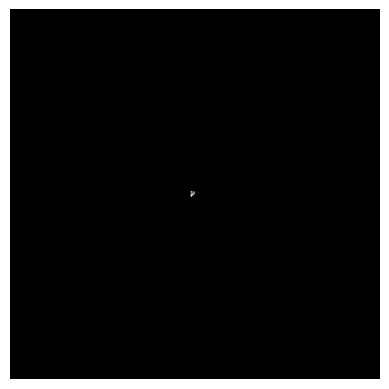

In [64]:
# initialise simulator
simulator = PhospheneSimulator(params, coordinates_visual_field)
N_PHOSPHENES = simulator.num_phosphenes

data_kwargs = get_data_kwargs(params)
device = data_kwargs['device']

RESOLUTION = params['run']['resolution']

# plot phosphenes for different input strengths
stims = np.array([80.])*1e-6

imgs = []
for i,stim in enumerate(stims):

    simulator.reset()
    stim_pattern = stim*torch.ones(N_PHOSPHENES,device=device)
    img = to_numpy(simulator(stim_pattern)).clip(max=1)[0]
    imgs.append(img)

    plt.imshow(img, cmap='gray', origin='lower')
    plt.axis('off')
    plt.show()

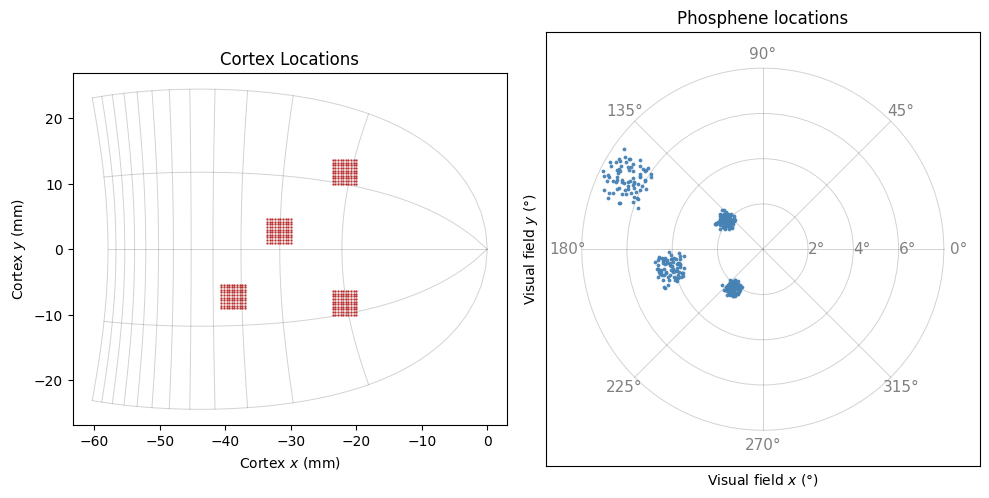

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# assume you already have:
#   coords_cortex, Map, visual_field_to_cortex, coordinates_visual_field
# and also a params dict with params['run']['view_angle']=16

view_angle = params['run']['view_angle']          # 16
half_angle = view_angle / 2                        # 8

fig, axs = plt.subplots(1, 2, figsize=(10, 5))



# --- Shared definitions ---
# Half‐circle in visual field (90°→270°)
phis_cortex = np.linspace(0.5*np.pi, 1.5*np.pi, 5)
# Radii for the retinotopic grid
radii = np.linspace(2, 25, 12)
phis_cortex = np.linspace(0.5*np.pi, 1.5*np.pi, 5)

# --- Cortex panel (Cartesian axes + retinotopic grid) ---
coords_cortex = coordinates_cortex.flip(hor=True, vert=False)
axs[0].scatter(*coords_cortex.cartesian,
               color='firebrick', s=0.5, alpha=0.85, zorder=3)
axs[0].set_title('Cortex Locations')


# Draw concentric (iso-radius) curves
for R in radii:
    φ = np.linspace(0.5*np.pi, 1.5*np.pi, 300)
    vf = Map(r=np.full_like(φ, R), phi=φ)
    w  = vf.flip(hor=True, vert=True).complex
    cc = Map(z=visual_field_to_cortex(w)).flip(hor=True, vert=False)
    axs[0].plot(*cc.cartesian,
                color='gray', lw=0.7, alpha=0.35, zorder=1)

# Draw radial (iso-angle) lines
for φ in phis_cortex:
    r_line = np.linspace(0, radii[-1], 200)
    vf = Map(r=r_line, phi=np.full_like(r_line, φ))
    w  = vf.flip(hor=True, vert=True).complex
    cc = Map(z=visual_field_to_cortex(w)).flip(hor=True, vert=False)
    axs[0].plot(*cc.cartesian,
                color='gray', lw=0.7, alpha=0.35, zorder=1)

# -- removed the zero‐lines here --
# axs[0].axhline(0, color='k', lw=0.8, zorder=2)
# axs[0].axvline(0, color='k', lw=0.8, zorder=2)

# Set ticks to cover your electrode range
# x_vals = np.arange(-60, 1, 20)
# y_vals = np.arange(-30, 31, 10)
# axs[0].set_xticks(x_vals)
# axs[0].set_yticks(y_vals)
axs[0].set_xlabel('Cortex $x$ (mm)')
axs[0].set_ylabel('Cortex $y$ (mm)')
axs[0].set_aspect('equal')

# --- Phosphene panel ---
r_vf, phi_vf = coordinates_visual_field.polar
px, py = r_vf * np.cos(phi_vf), r_vf * np.sin(phi_vf)
axs[1].scatter(px, py,
               s=3, alpha=0.9, color='steelblue',
                 zorder=3)
axs[1].set_title('Phosphene locations')

# use view‐angle to define the max radial extent
max_rad = half_angle

# make a little padding so points do not touch border
pad = 0.2 * max_rad
xlim = (-max_rad - pad, max_rad + pad)
ylim = (-max_rad - pad, max_rad + pad)

# concentric circles + radial lines
circle_radii = np.linspace(2, max_rad, 4)
phis_full   = np.linspace(0, 2*np.pi, 8, endpoint=False)
deg_labels  = np.arange(0, 360, 45)

for R in circle_radii:
    circ = plt.Circle((0,0), R,
                      color='gray', fill=False,
                      lw=0.7, alpha=0.35, zorder=1)
    axs[1].add_artist(circ)

for φ,deg in zip(phis_full, deg_labels):
    axs[1].plot([0, max_rad*np.cos(φ)],
                [0, max_rad*np.sin(φ)],
                color='gray', lw=0.7,
                alpha=0.35, zorder=1)
    axs[1].text(1.08*max_rad*np.cos(φ),
                1.08*max_rad*np.sin(φ),
                f"{deg}°", fontsize=11,
                ha='center', va='center',
                color='gray')

# radial (distance) labels on horizontal
for R in circle_radii[:-1]:
    axs[1].text(R, 0,
                f"{int(R)}°",
                fontsize=11,
                ha='left', va='center',
                color='gray')

axs[1].set_aspect('equal')
axs[1].set_xlim(*xlim)
axs[1].set_ylim(*ylim)
axs[1].set_xlabel('Visual field $x$ (°)')
axs[1].set_ylabel('Visual field $y$ (°)')
axs[1].set_xticks([])
axs[1].set_yticks([])

# # make squares equal size
# axs[1].set_box_aspect(1)  # Ensures equal aspect ratio for squares
# axs[0].set_box_aspect(1.1)


plt.tight_layout()
plt.show()


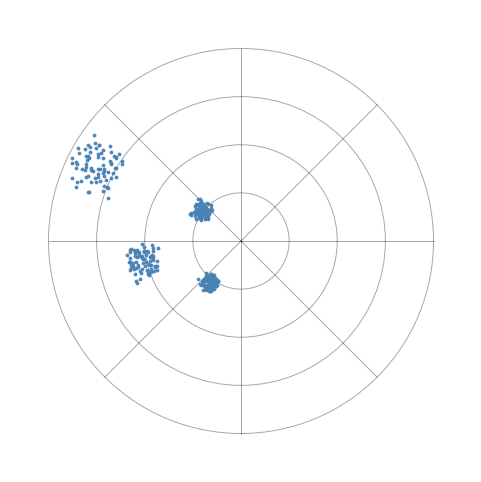

In [28]:
# plot only the phosphene locations in the visual fiel, no axis labels
plt.figure(figsize=(6, 6))
plt.scatter(px, py, s=3, alpha=0.9, color='steelblue', zorder=3)
plt.axis('off')

# add circle radii
for R in circle_radii:
    circ = plt.Circle((0, 0), R, color='black', fill=False, lw=0.7, alpha=0.35, zorder=1)
    plt.gca().add_artist(circ)

# add radial lines
for φ, deg in zip(phis_full, deg_labels):
    plt.plot([0, max_rad * np.cos(φ)], [0, max_rad * np.sin(φ)],
             color='black', lw=0.7, alpha=0.35, zorder=1)


plt.xlim(-max_rad - pad, max_rad + pad)
plt.ylim(-max_rad - pad, max_rad + pad)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()



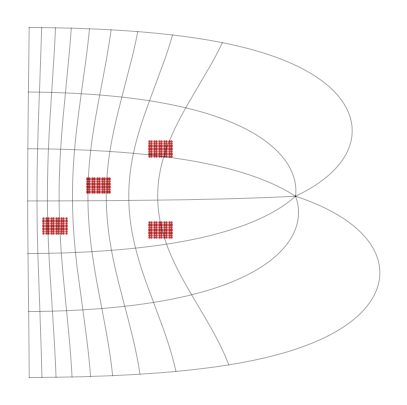

In [29]:
phi_min, phi_max = 0.15*np.pi, 1.8*np.pi   # much wider angular coverage
radii    = np.linspace(2, 9, 9)
phis_spokes = np.linspace(phi_min, phi_max, 7)

plt.figure(figsize=(5,5))
plt.scatter(*coords_cortex.cartesian, marker='.', s=2, color='firebrick', alpha=0.85)

# draw iso‐radius arcs
for R in radii:
    φ = np.linspace(phi_min, phi_max, 300)
    vf = Map(r=np.full_like(φ, R), phi=φ)
    w  = vf.flip(hor=True, vert=True).complex
    cc = Map(z=visual_field_to_cortex(w)).flip(hor=True, vert=False)
    plt.plot(*cc.cartesian, color='black', lw=0.7, alpha=0.35)

# draw iso‐angle spokes
for φ0 in phis_spokes:
    r_line = np.linspace(0, radii[-1], 300)
    vf     = Map(r=r_line, phi=np.full_like(r_line, φ0))
    w      = vf.flip(hor=True, vert=True).complex
    cc     = Map(z=visual_field_to_cortex(w)).flip(hor=True, vert=False)
    plt.plot(*cc.cartesian, color='black', lw=0.7, alpha=0.35)

plt.axis('off')
plt.show()


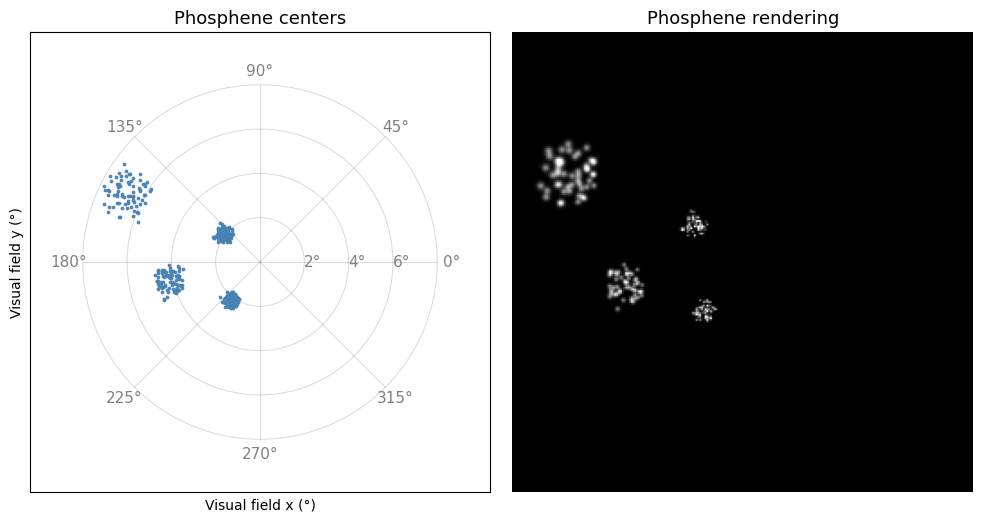

In [31]:
import numpy as np
import torch
import matplotlib.pyplot as plt

view_angle = params['run']['view_angle']   # e.g. 16°
half_angle  = view_angle / 2               # 8°

# Prepare phosphene centers
r_vf, phi_vf = coordinates_visual_field.polar
px, py       = r_vf * np.cos(phi_vf), r_vf * np.sin(phi_vf)

# Prepare simulator output
sim        = PhospheneSimulator(params, coordinates_visual_field)
sim.reset()
stim       = 80e-6 * torch.ones(sim.num_phosphenes, device=get_data_kwargs(params)['device'])
phos_image = sim(stim).cpu().numpy()[0].clip(0,1)

# Plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# --- Left: phosphene centers ---
axs[0].scatter(px, py, s=3, color='steelblue', alpha=0.9, zorder=3)
axs[0].set_title('Phosphene centers', fontsize=13)

# concentric circles
circle_rads = np.linspace(2, half_angle, 4)
phis_full   = np.linspace(0, 2*np.pi, 8, endpoint=False)
deg_labels  = np.arange(0, 360, 45)
for R in circle_rads:
    c = plt.Circle((0,0), R, edgecolor='gray', facecolor='none', lw=0.7, alpha=0.3, zorder=1)
    axs[0].add_artist(c)
for φ, deg in zip(phis_full, deg_labels):
    axs[0].plot([0, half_angle*np.cos(φ)], [0, half_angle*np.sin(φ)],
                color='gray', lw=0.7, alpha=0.3, zorder=1)
    axs[0].text(1.08*half_angle*np.cos(φ),
                1.08*half_angle*np.sin(φ),
                f"{deg}°", color='gray', fontsize=11,
                ha='center', va='center')

# radius labels
for R in circle_rads[:-1]:
    axs[0].text(R, 0, f"{int(R)}°", color='gray', fontsize=11,
                ha='left', va='center')

axs[0].set_aspect('equal')
zoom = half_angle * 1.3   # zoom out factor
axs[0].set_xlim(-zoom, zoom)
axs[0].set_ylim(-zoom, zoom)
axs[0].set_xlabel('Visual field x (°)')
axs[0].set_ylabel('Visual field y (°)')
axs[0].set_xticks([]); axs[0].set_yticks([])

# --- Right: phosphene rendering ---
axs[1].imshow(phos_image, cmap='gray', origin='lower')
axs[1].axis('off')
axs[1].set_title('Phosphene rendering', fontsize=13)

plt.tight_layout()
plt.show()
